# BOOSTING AND ADABOOST CLASSIFIER

Prima di iniziare a costruire il modello con la realative ricerca degli iperparametri migliori dobbiamo fare la preparazione del dataset. Per questo scopo creiamo un dataset esteso che racchiude tutte le informazioni rimaste delle gare e include nelle righe le informazioni dei ciclisti 

## DATASET PREPARATION

In [26]:
import pandas as pd
from os import path
import numpy as np

races_final_path = path.join('..','dataset', 'races_cleaned.csv')
cyclists_final_path = path.join('..','dataset', 'cyclists_cleaned.csv')


cyclists_data = pd.read_csv(cyclists_final_path)
races_data = pd.read_csv(races_final_path)

cyclists_data.rename(columns={'name': 'cyclist'}, inplace=True)

merged_data = races_data.merge(cyclists_data, left_on='cyclist', right_on='_url', how='inner')

merged_data['top_20'] = merged_data['position'].apply(lambda x: 1 if x <= 20 else 0)


merged_data['date'] = pd.to_datetime(merged_data['date'])

columns_to_keep = [
    'difficulty_score','competitive_age','is_tarmac','delta','points','climbing_efficiency',
    'bmi','career_points', 'career_duration(days)', 'debut_year','top_20'
]


train_set = merged_data[merged_data['date'] < '2022-01-01']
test_set = merged_data[merged_data['date'] >= '2022-01-01']

train_set = train_set[columns_to_keep]
test_set = test_set[columns_to_keep]

X_train = train_set.drop(columns=['top_20'])
y_train = train_set['top_20']


X_test = test_set.drop(columns=['top_20'])
y_test = test_set['top_20']
X_train.shape

KeyError: "['difficulty_score', 'competitive_age', 'climbing_efficiency', 'bmi', 'career_points', 'career_duration(days)', 'debut_year'] not in index"

## Boosting

Il boosting in generale è la pratica che prende in considerazione più classificatori base deboli ("weak learner") e li traina in modo indipendente sulle medesime porzioni del dataset. Inizialmente viene scelto il classificatore poi parte il processo di training, ogni weak learner addestrato viene valutato in base all'errore finale dopo il training. Alla fine ci si ritroveranno "n_estimators" stimatori che faranno una votazione (pesata in base all'errore) per decidere l'etichetta delle righe ancora non classificate.

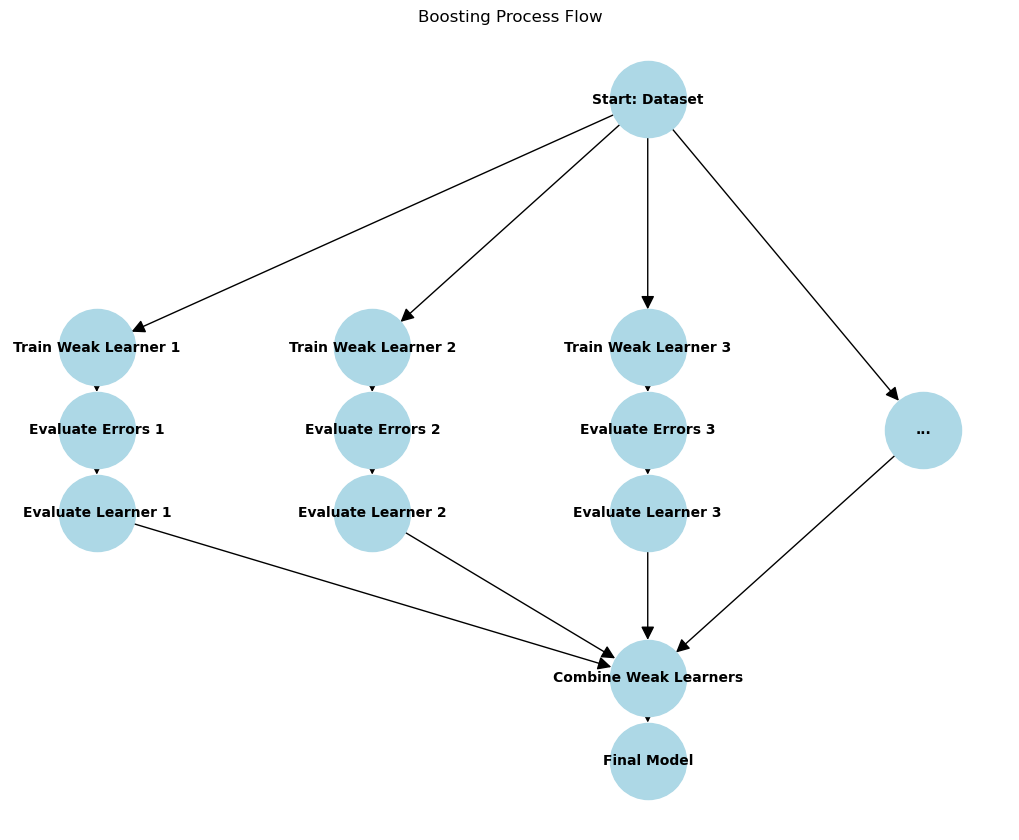

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

G.add_node("Start: Dataset", pos=(-1, 6))

G.add_node("Train Weak Learner 1", pos=(-3, 3))
G.add_node("Evaluate Errors 1", pos=(-3, 2))
G.add_node("Evaluate Learner 1", pos=(-3, 1))

G.add_node("Train Weak Learner 2", pos=(-2, 3))
G.add_node("Evaluate Errors 2", pos=(-2, 2))
G.add_node("Evaluate Learner 2", pos=(-2, 1))

G.add_node("Train Weak Learner 3", pos=(-1, 3))
G.add_node("Evaluate Errors 3", pos=(-1, 2))
G.add_node("Evaluate Learner 3", pos=(-1, 1))

G.add_node("...", pos=(0, 2))

G.add_node("Combine Weak Learners", pos=(-1, -1))
G.add_node("Final Model", pos=(-1, -2))


G.add_edges_from([
    ("Start: Dataset", "Train Weak Learner 1"),
    ("Start: Dataset", "Train Weak Learner 2"),
    ("Start: Dataset", "Train Weak Learner 3"),
    ("Start: Dataset", "..."),

    ("Train Weak Learner 1", "Evaluate Errors 1"),
    ("Evaluate Errors 1", "Evaluate Learner 1"),
    ("Evaluate Learner 1", "Combine Weak Learners"),

    ("Train Weak Learner 2", "Evaluate Errors 2"),
    ("Evaluate Errors 2", "Evaluate Learner 2"),
    ("Evaluate Learner 2", "Combine Weak Learners"),

    ("Train Weak Learner 3", "Evaluate Errors 3"),
    ("Evaluate Errors 3", "Evaluate Learner 3"),
    ("Evaluate Learner 3", "Combine Weak Learners"),

    ("...", "Combine Weak Learners"),

    ("Combine Weak Learners", "Final Model")
])

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Boosting Process Flow")
plt.show()

## XGBOOST

XGBoost, "Extreme Gradient Boost" nello specifico utilizza gli alberi decisionali come weak learner in quanto questi si adattano particolarmente bene al gradient boosting.
Con questa tecnica si possono costruire alberi in modo incrementale, una volta creato un albero successivo viene definito per ridurre gli errori residui del precedente, la direzione nel quale modificare i parametri viene decisa tramite il gradiente. In particolare il XG Boost non utilizza un peso per i sample male interpretati ma utilizza l'errore residuo per la costruzione del prossimo albero decisionale, che mirerà a controbilanciare l'errore del precedente (anche prendendo in considerazione il learning rate).

ypred^(t+1)(x) = ypred^(t)(x)+ eta * f^(t)(x)

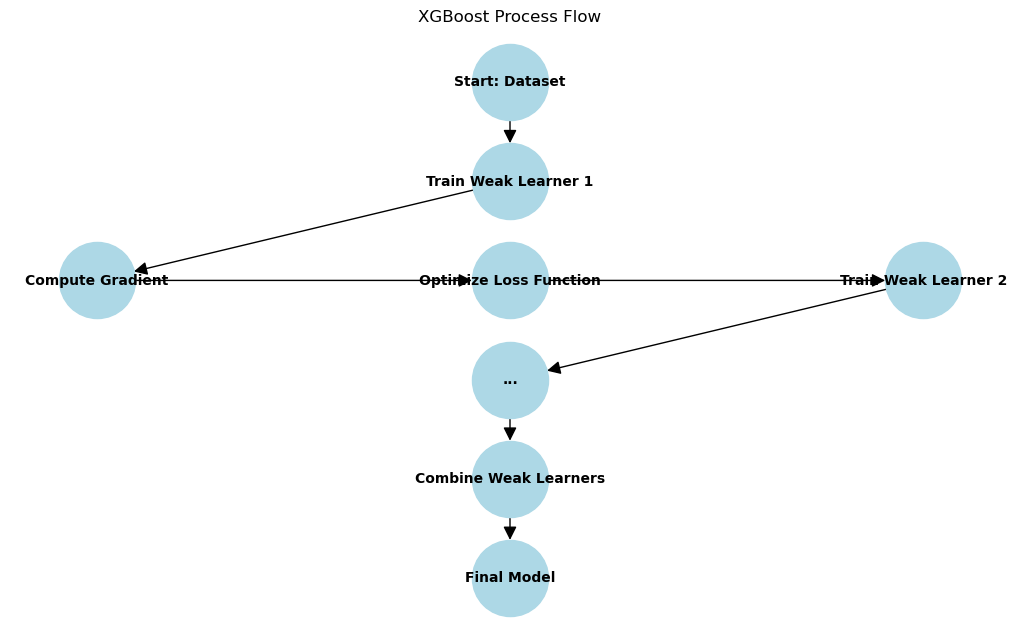

In [ ]:
G = nx.DiGraph()

G.add_node("Start: Dataset", pos=(0, 4))
G.add_node("Train Weak Learner 1", pos=(0, 3))
G.add_node("Compute Gradient", pos=(-1, 2))
G.add_node("Optimize Loss Function", pos=(0, 2))
G.add_node("Train Weak Learner 2", pos=(1, 2))
G.add_node("...", pos=(0, 1))
G.add_node("Combine Weak Learners", pos=(0, 0))
G.add_node("Final Model", pos=(0, -1))

G.add_edges_from([
    ("Start: Dataset", "Train Weak Learner 1"),
    ("Train Weak Learner 1", "Compute Gradient"),
    ("Compute Gradient", "Optimize Loss Function"),
    ("Optimize Loss Function", "Train Weak Learner 2"),
    ("Train Weak Learner 2", "..."),
    ("...", "Combine Weak Learners"),
    ("Combine Weak Learners", "Final Model")
])

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("XGBoost Process Flow")
plt.show()

- Iperparametri per la scelta dell'approccio, (tipo di learner, come viene valutato l'errore, funzione di ottimizzazione), in questo caso lasciamo quelli base in quanto la libreria fornisce già quelli migliori.

- Iperparametri per l’albero decisionale (modello base)

		max_depth:
	        Profondità massima degli alberi. Alberi più profondi possono catturare più complessità, ma aumentano il rischio di overfitting.


		min_child_weight:
		    Peso minimo per ogni nodo foglia. Un valore più alto riduce la probabilità di divisione e di overfitting.


		subsample: (Controllato nella preparazione del dataset)
		    Percentuale dei dati da utilizzare per addestrare ogni albero. Un valore inferiore può migliorare la generalizzazione, ma rischia di ridurre l’efficacia dell’apprendimento.


		gamma:
            Maggiore valore di gamma significa che sono necessari guadagni più significativi per effettuare una divisione in un nodo.


		lambda (regolarizzazione L2):
	        Termina di regolarizzazione L2 per prevenire l’overfitting.

		alpha (regolarizzazione L1): (Non utilizzato)
        	Termina di regolarizzazione L1 per prevenire l’overfitting.


		colsample_bytree: (Non utilizzato)
	        Percentuale di caratteristiche (colonne) da utilizzare per ogni albero.

		colsample_bylevel: (Non utilizzato)
	        Percentuale di caratteristiche da utilizzare per ogni livello dell’albero (più fine rispetto a colsample_bytree).

		colsample_bynode: (Non utilizzato)
	        Percentuale di caratteristiche da usare per ogni nodo dell’albero.


-Iperparametri di boosting e apprendimento

		learning_rate (eta):
	        Rende ogni aggiornamento più piccolo e aiuta a migliorare la generalizzazione. Valori più piccoli richiedono più alberi.


		n_estimators:
	        Numero di alberi da costruire.


		scale_pos_weight: (Se necessario)
	        Viene utilizzato nel caso di classi sbilanciate. Controlla la ponderazione per la classe positiva.


		early_stopping_rounds: (Se necessario)
            Se il punteggio non migliora per un numero di iterazioni specificato, il training viene interrotto.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tqdm import tqdm

base_model = XGBClassifier()

hyperparameters = {
    "max_depth": [2, 3], # Maximum depth of the tree
    "min_child_weight": [1, 2, 3], # Minimum sum of instance weight needed in a child
    "gamma": [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
    "lambda": [0, 1, 2], # L2 regularization term on weights

    "learning_rate": [1, 0.1, 0.001, 0.0001], #eta, step size shrinkage
    "n_estimators": [25, 100, 250], # Number of trees
}


search = GridSearchCV(base_model, hyperparameters)
search.fit(X_train, y_train)
clf = search.best_estimator_
clf.fit(X_train, y_train)


print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)
print("Best Estimator:", search.best_estimator_)

Best Parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1}
Best Score: 0.8609653830286927


In [ ]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , GridSearchCV, train_test_split,ParameterGrid
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED=42
NUM_FOLDS=5

hyperparameters = {
    "max_depth": [2, 3], # Maximum depth of the tree
    "min_child_weight": [1, 2, 3], # Minimum sum of instance weight needed in a child
    "gamma": [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
    "lambda": [0, 1, 2], # L2 regularization term on weights

    "learning_rate": [1, 0.1, 0.001, 0.0001], #eta, step size shrinkage
    "n_estimators": [25, 100, 250], # Number of trees
}

grid_params=ParameterGrid(hyperparameters)

X_train_set, X_val_set, Y_train_set, Y_val_set = train_test_split(
    X_train,y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
    shuffle=True
)

params_tested=list()

for comb in grid_params:
    rfc=XGBClassifier(**comb)
    rfc=rfc.fit(X_train_set,Y_train_set)

    Y_pred_val_set=rfc.predict(X_val_set)

    train_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted')
    val_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted')
    new_comb=comb
    new_comb|={
        'train_f1_score':train_f_score,
        'val_f1_score':val_f_score,
    }
    print(comb)
    report_scores(Y_val_set,Y_pred_val_set)
    params_tested.append(new_comb)

params_df=pd.DataFrame(params_tested)


params_df.sort_values(by='val_f1_score')

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 25, 'train_f1_score': np.float64(0.8304255983854902), 'val_f1_score': np.float64(0.8304255983854902)}
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     92129
           1       0.69      0.28      0.40     18763

    accuracy                           0.86    110892
   macro avg       0.78      0.63      0.66    110892
weighted avg       0.84      0.86      0.83    110892

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 100, 'train_f1_score': np.float64(0.8455710386279742), 'val_f1_score': np.float64(0.8455710386279742)}
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     92129
           1       0.71      0.35      0.47     18763

    accuracy                           0.87    110892
   macro avg       0.79      0.66      0.69    110892
weighted avg       0.85      0.87      0.85    110892

{'learning_rate': 1, 'max_depth': 2

/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 250, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 25, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 25, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 250, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 25, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 250, 'train_f1_score': np.float64(0.7540176834235754), 'val_f1_score': np.float64(0.7540176834235754)}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     92129
           1       0.00      0.00      0.00     18763

    accuracy                           0.83    110892
   macro avg       0.42      0.50      0.45    110892
weighted avg       0.69      0.83      0.75    110892



/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filippomorelli/miniconda3/envs/dmproj/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,learning_rate,max_depth,n_estimators,train_f1_score,val_f1_score
23,0.0001,3,250,0.754018,0.754018
14,0.0010,2,250,0.754018,0.754018
13,0.0010,2,100,0.754018,0.754018
12,0.0010,2,25,0.754018,0.754018
22,0.0001,3,100,0.754018,0.754018
15,0.0010,3,25,0.754018,0.754018
16,0.0010,3,100,0.754018,0.754018
17,0.0010,3,250,0.754018,0.754018
18,0.0001,2,25,0.754018,0.754018
19,0.0001,2,100,0.754018,0.754018


## ADABOOST
Il AdaBoost, acronimo di "Adaptive boosting", utilizza invece un approccio diverso. Se il XGboost utilizzava un approccio incrementale basato sul correggere la predizione dell'albero precedente il Adaboost utilizza un approccio più tipico ovvero pesando i modelli esplicitamente. La particolarità del Adaboost rispetto ai modelli di boosting classico è che gli errori nell'iterazione precedente diventano un peso nei sample coinvolti, su cui si concentrerà il prossimo learner. Questa aggiunta permette di avere anche qui un approccio incrementale che migliora le prestazioni del modello complessivo focalizzandosi sugli esempi più comeplessi da predirre (ad ogni iterazione il vettore dei pesi viene normalizzato per non sbilanciare un iterazione).



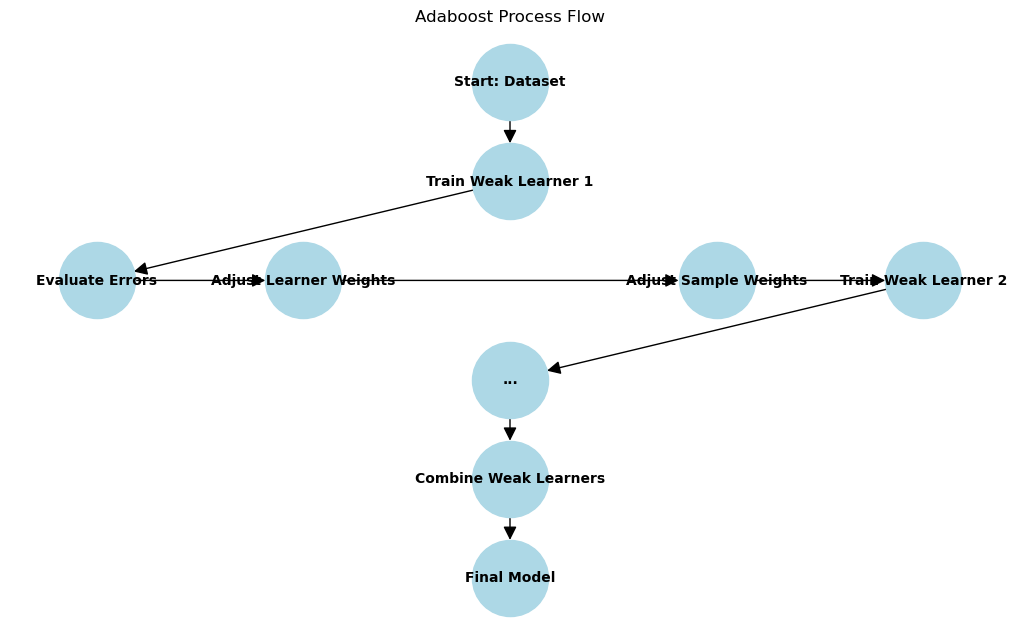

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Start: Dataset", pos=(0, 4))
G.add_node("Train Weak Learner 1", pos=(0, 3))
G.add_node("Evaluate Errors", pos=(-2, 2))
G.add_node("Adjust Learner Weights", pos=(-1, 2))
G.add_node("Adjust Sample Weights", pos=(1, 2))
G.add_node("Train Weak Learner 2", pos=(2, 2))
G.add_node("...", pos=(0, 1))
G.add_node("Combine Weak Learners", pos=(0, 0))
G.add_node("Final Model", pos=(0, -1))

# Add edges
G.add_edges_from([
    ("Start: Dataset", "Train Weak Learner 1"),
    ("Train Weak Learner 1", "Evaluate Errors"),
    ("Evaluate Errors", "Adjust Learner Weights"),
    ("Adjust Learner Weights", "Adjust Sample Weights"),
    ("Adjust Sample Weights", "Train Weak Learner 2"),
    ("Train Weak Learner 2", "..."),
    ("...", "Combine Weak Learners"),
    ("Combine Weak Learners", "Final Model")
])

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Adaboost Process Flow")
plt.show()

A differenza del XGBoost, creato appositamente per gli alberi decisionali, per i weak learner del AdaBoost possono posso utilizzare Logistic Regression (con threshold), KNN, e anche qui alberi decisionali. Volendo si potrebbero utilizzare modelli più complessi come le SVM ma in quanto non molto "weak" l'intero processo di training diventerebbe troppo pesante.

Gli iperparametri utilizzati sono:


1. Iperparametri per la creazione del modello base 

	-base_estimator:
		Modello di base da utilizzare. Può essere un modello qualsiasi, ma generalmente si usano alberi decisionali deboli, come DecisionTreeClassifier(max_depth=1).


	-n_estimators:
		Numero di modelli (alberi) deboli da addestrare. Più alberi possono migliorare la performance, ma aumentano il rischio di overfitting.


2. Iperparametri di controllo della pesatura

	-Learning_rate:
		Controlla l’impatto di ogni classificatore debole sull’output finale. Un valore inferiore riduce l’impatto di ciascun albero.


3. Iperparametri di regolazione e ottimizzazione

	-algorithm:
	    Metodo di combinazione degli alberi: 'SAMME' (Metodo di boosting classico)

4. Iperparametri di stopping (interruzione anticipata)

	r-andom_state:
		Seed per la generazione di numeri casuali. Utile per la riproducibilità dei risultati.


In [ ]:

hyperparameters = {
    "n_estimators": [25, 50, 100], # Number of weak learners
    "learning_rate": [1, 0.1, 0.01], # Weight of the weak learners
    "algorithm": ['SAMME', 'SAMME.R'], # Algorithm to use
    "random_state": [42] # Random seed
}


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

tree_base = tree.DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=tree_base, n_estimators=200, learning_rate=0.1, algorithm='SAMME')
clf.fit(X_train, y_train)

test_pred_clf = clf.predict(X_test)
print(classification_report(y_test, 
                            test_pred_clf, 
                            target_names=['No_Top_20', 'Top_20']))

from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , GridSearchCV, train_test_split,ParameterGrid
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED=42
NUM_FOLDS=5

hyperparameters = {
    "n_estimators": [25, 50, 100], # Number of weak learners
    "learning_rate": [1, 0.1, 0.01], # Weight of the weak learners
    "algorithm": ['SAMME'], # Algorithm to use
}

grid_params=ParameterGrid(hyperparameters)

X_train_set, X_val_set, Y_train_set, Y_val_set = train_test_split(
    X_train,y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
    shuffle=True
)

params_tested=list()

for comb in grid_params:
    tree_base = tree.DecisionTreeClassifier(max_depth=5) # Decision tree as weak learner using the baset parametrers fuoudn in the previous step
    rfc = AdaBoostClassifier(estimator=tree_base, **comb)
    rfc=rfc.fit(X_train_set,Y_train_set)

    Y_pred_val_set=rfc.predict(X_val_set)

    train_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted')
    val_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted')
    new_comb=comb
    new_comb|={
        'train_f1_score':train_f_score,
        'val_f1_score':val_f_score,
    }
    print(comb)
    report_scores(Y_val_set,Y_pred_val_set)
    params_tested.append(new_comb)

params_df=pd.DataFrame(params_tested)


params_df.sort_values(by='val_f1_score')

              precision    recall  f1-score   support

   No_Top_20       0.88      0.98      0.93     30219
      Top_20       0.69      0.25      0.37      5187

    accuracy                           0.87     35406
   macro avg       0.79      0.61      0.65     35406
weighted avg       0.86      0.87      0.85     35406



In [ ]:
from sklearn.linear_model import LogisticRegression

log_base = LogisticRegression(solver='lbfgs', max_iter=1000)
clf2 = AdaBoostClassifier(estimator=log_base, n_estimators=200, learning_rate=0.1, algorithm='SAMME')
clf2.fit(X_train, y_train)

test_pred_clf2 = clf2.predict(X_test)
print(classification_report(y_test, 
                            test_pred_clf2, 
                            target_names=['No_Top_20', 'Top_20']))

from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

tree_base = tree.DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=tree_base, n_estimators=200, learning_rate=0.1, algorithm='SAMME')
clf.fit(X_train, y_train)

test_pred_clf = clf.predict(X_test)
print(classification_report(y_test, 
                            test_pred_clf, 
                            target_names=['No_Top_20', 'Top_20']))

from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , GridSearchCV, train_test_split,ParameterGrid
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED=42
NUM_FOLDS=5

hyperparameters = {
    "n_estimators": [25, 50, 100], # Number of weak learners
    "learning_rate": [1, 0.1, 0.01], # Weight of the weak learners
    "algorithm": ['SAMME'], # Algorithm to use
}

grid_params=ParameterGrid(hyperparameters)

X_train_set, X_val_set, Y_train_set, Y_val_set = train_test_split(
    X_train,y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
    shuffle=True
)

params_tested=list()

for comb in grid_params:
    tree_base = tree.DecisionTreeClassifier(max_depth=5) # Decision tree as weak learner using the baset parametrers fuoudn in the previous step
    rfc = AdaBoostClassifier(estimator=tree_base, **comb)
    rfc=rfc.fit(X_train_set,Y_train_set)

    Y_pred_val_set=rfc.predict(X_val_set)

    train_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted')
    val_f_score=f1_score(Y_val_set,Y_pred_val_set,average='weighted')
    new_comb=comb
    new_comb|={
        'train_f1_score':train_f_score,
        'val_f1_score':val_f_score,
    }
    print(comb)
    report_scores(Y_val_set,Y_pred_val_set)
    params_tested.append(new_comb)

params_df=pd.DataFrame(params_tested)


params_df.sort_values(by='val_f1_score')


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_base = KNeighborsClassifier(n_neighbors=3)
clf3 = AdaBoostClassifier(estimator=knn_base, n_estimators=200, learning_rate=0.1, algorithm='SAMME')
clf3.fit(X_train, y_train)
test_pred_clf3 = clf3.predict(X_test)
print(classification_report(y_test, 
                            test_pred_clf3, 
                            target_names=['No_Top_20', 'Top_20']))